# Intermediate Machine Learning: Assignment 2

**Deadline**

Assignment 2 is due Wednesday, October 9 11:59pm. Late work will not be accepted as per the course policies (see the Syllabus and Course policies on Canvas).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission**

Submit your assignment as a pdf file on Gradescope, and as a notebook (.ipynb) on Canvas. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to more easily find your complete solution to each problem.

To produce the .pdf, please do the following in order to preserve the cell structure of the notebook:

Go to "File" at the top-left of your Jupyter Notebook
Under "Download as", select "HTML (.html)"
After the .html has downloaded, open it and then select "File" and "Print" (note you will not actually be printing)
From the print window, select the option to save as a .pdf

**Topics**

 * Convolutional neural networks
 * Gaussian processes
 * Double descent

This assignment will also help to solidify your Python and Jupyter notebook skills.


## Problem 1: It's not a bug, it's a feature! (20 points)

In this problem, we will ["open the black box"](https://news.yale.edu/2018/12/10/why-take-ydata-because-data-science-shouldnt-be-black-box) and inspect the filters and feature maps learned by a convolutional neural network trained to classify handwritten digits, using the MNIST database.

In [322]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### 1.1 Visualizing the filters

To begin, we load the dataset with 60000 training images and 10000 test images.

In [323]:
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train_binary = keras.utils.to_categorical(y_train, num_classes)
y_test_binary = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Next, we initialize our convolutional neural network.

In [324]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu", name='conv1'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu", name='conv2'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 8, 8, 32)          25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0

In [325]:
batch_size = 128
epochs = 1

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train_binary, batch_size=batch_size, epochs=epochs, validation_split=0.1)

422/422 [==============================] - 10s 23ms/step - loss: 0.4138 - accuracy: 0.8705 - val_loss: 0.0839 - val_accuracy: 0.9783


In [326]:
score = model.evaluate(x_test, y_test_binary, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.09532573819160461
Test accuracy: 0.9714999794960022


Now that we've trained and tested the model, let's look at the filters learned in the first convolutional layer.

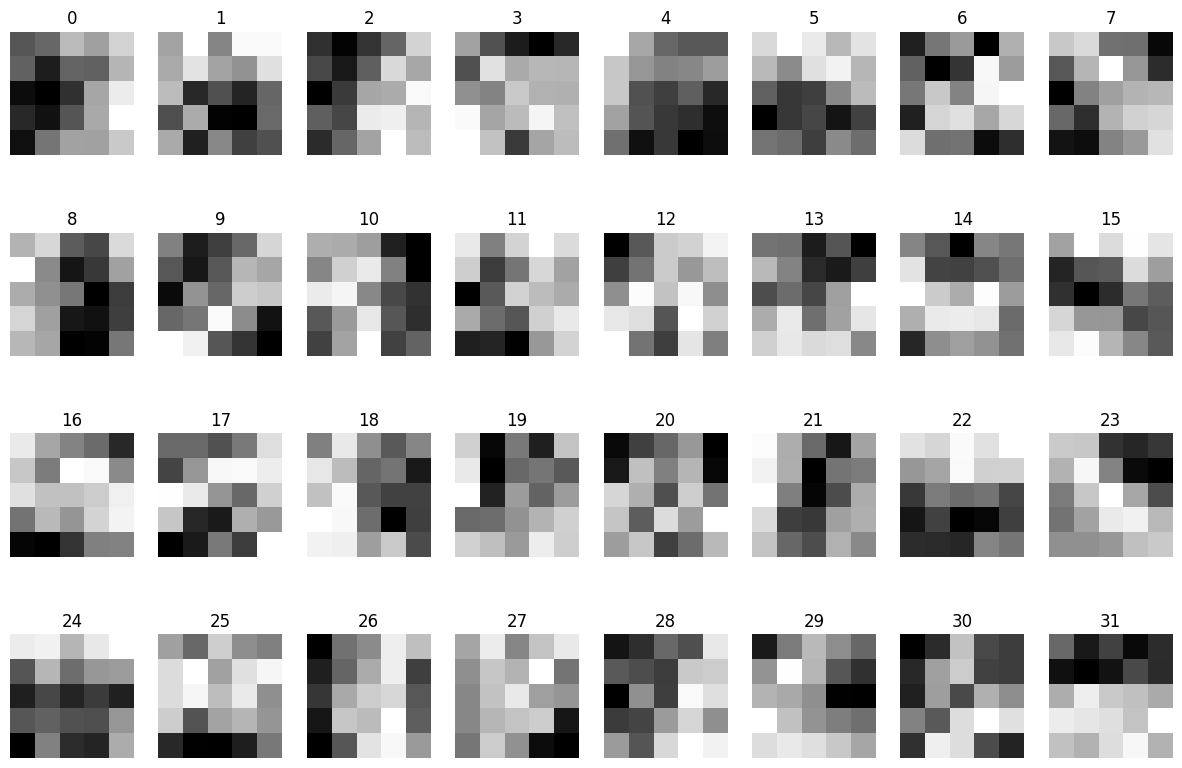

In [330]:
filters_conv1 = model.get_layer(name='conv1').get_weights()[0]

fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

for i in range(4):
    for j in range(8):
        f = filters_conv1[:, :, 0, 8*i+j]
        axs[i, j].imshow(f[:, :], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(8*i+j)

Describe what you see. Do (some of) the learned filters make sense to you?

Hint: Many filters have been designed and widely applied in image processing. [Here](http://www.theobjects.com/dragonfly/dfhelp/3-5/Content/05_Image%20Processing/Edge%20Detection%20Filters.htm) are some examples of edge detection filters and their effect on the image. You can find the details about each filter by clicking the links at the bottom.

### Answer
The image display the 32 5x5 filters of our first CNN layer. Many of the filters appear to highlight basic patterns such as edges or contours, similar to common image processing filters such as Sobel or Prewitt, which are often used for edge detection. This is shown in filter that have more many dark squares or light squares in a concrete edge pattern. Some filters seem to capture diagonal lines and gradients, which are used to differentiate between digits such as 4 or 8. These patterns make sense because the first CNN layer typically focuses on extracting fundamental features, like edges, which are then used by deeper layers to recognize more complex structures.








### 1.2 Visualizing the feature maps

We can also look at the corresponding feature map for each filter. There are 32 kernels at the first convolutional layer, so there are 32 feature maps for each sample. feature_map_conv1 is a 4D matrix where the first dimension is the index of the sample and the last dimension is the index of the correpsonding filter.

In [334]:
conv1_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer('conv1').output)
feature_map_conv1 = conv1_layer_model(x_test)

Randomly draw 16 samples for visualization.

In [335]:
sample_index = random.sample(range(1, len(x_test)), 16)

Choose two filters among all 32 filters from 2.1, and visualize their feature maps.

In [346]:
filter_n1 = 31
filter_n2 = 17

There is no need to modify the next code cells, just run the four cells below.

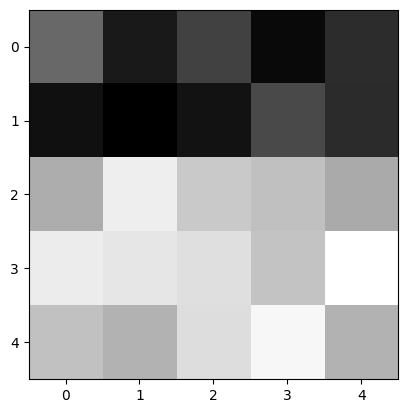

In [347]:
plt.imshow(filters_conv1[:, :, 0, filter_n1], cmap='gray')

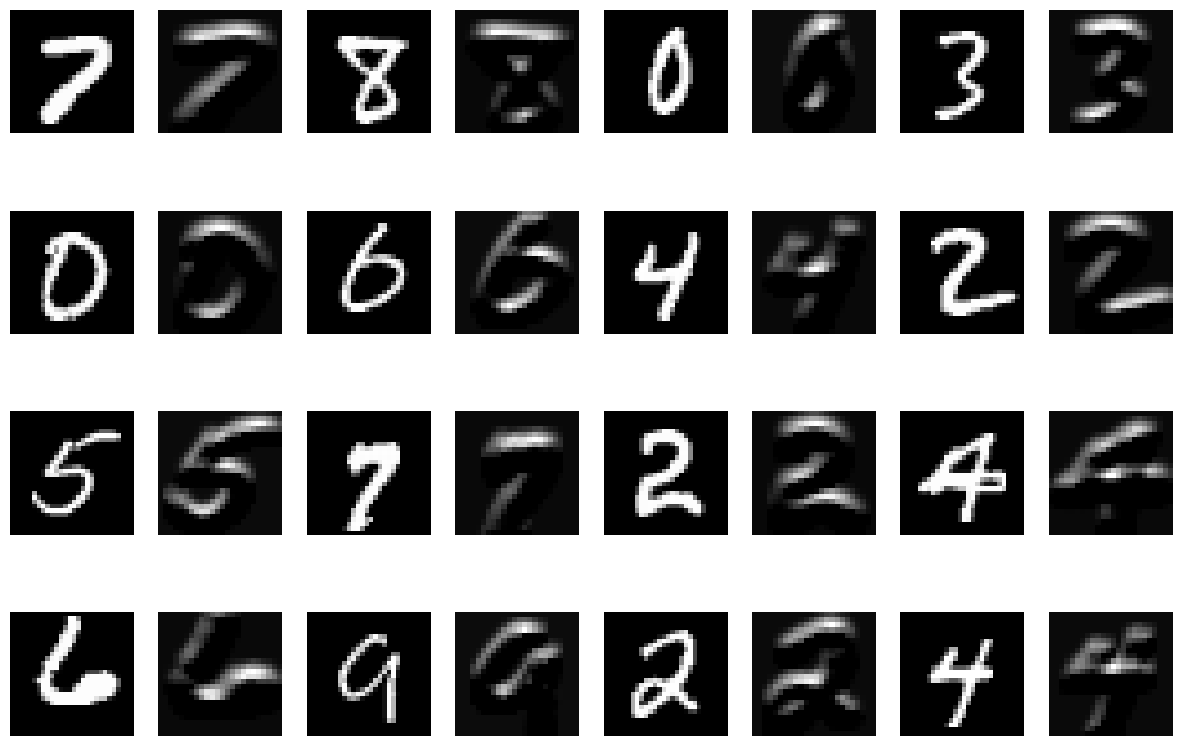

In [348]:
fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

ix=0
for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(x_test[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(feature_map_conv1[sample_index[4*i+j], :, :, filter_n1], cmap='gray')
        axs[i, 2*j+1].axis('off')

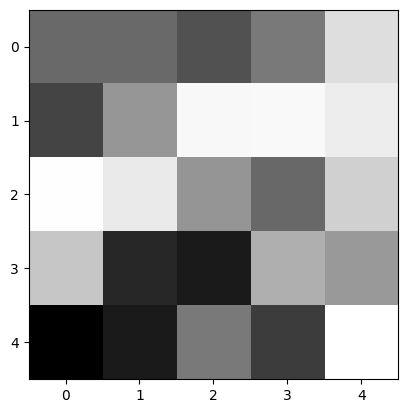

In [349]:
plt.imshow(filters_conv1[:, :, 0, filter_n2], cmap='gray')

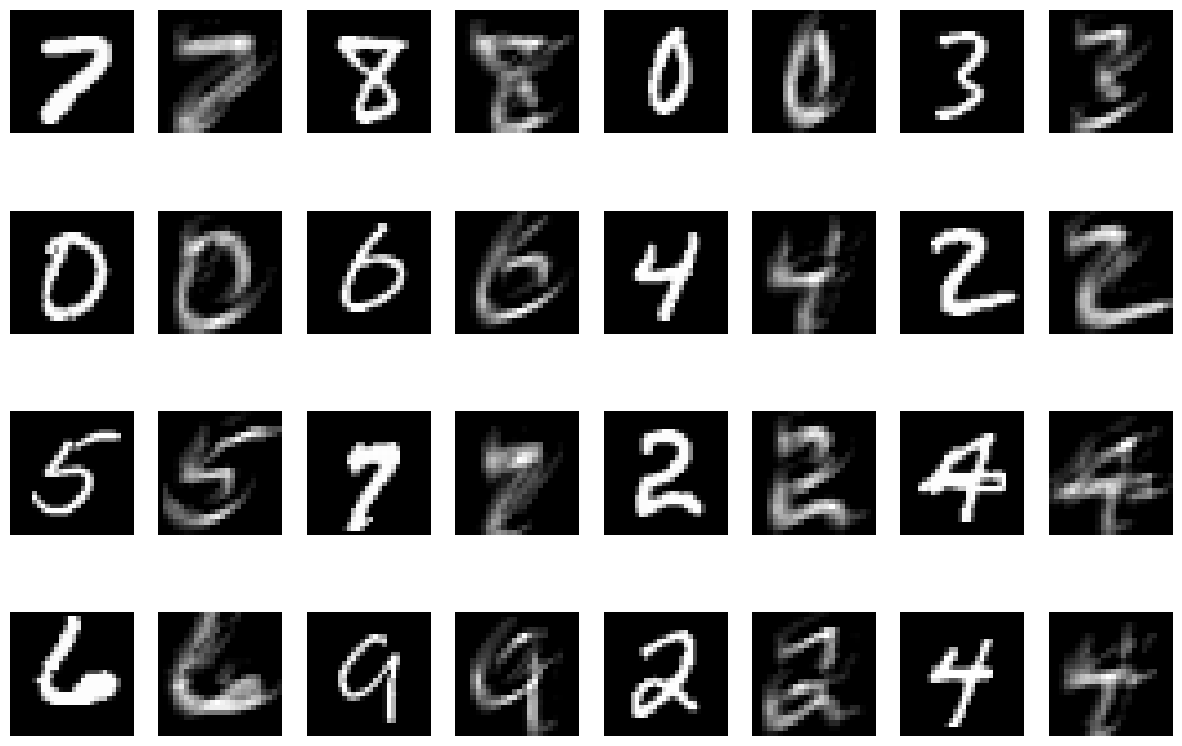

In [350]:
fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

ix=0
for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(x_test[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(feature_map_conv1[sample_index[4*i+j], :, :, filter_n2], cmap='gray')
        axs[i, 2*j+1].axis('off')

Comment on what you see in the feature maps.
* How do they correspond to the original images?
* How do they correspond to the filters?
* Why might the feature maps be helpful for classifying digits?

### Answer
For Filter 31, the feature maps are highly focused on edges, capturing prominent horizontal lines that define the structure of digits like "2." For example, the feature map for the digit "2" clearly emphasizes the three horizontal edges that form its main shape. This aligns well with the corresponding filter, which appears to be edge-detection based, with a distinct separation between low and high weights, likely designed to highlight such linear features.

In contrast, Filter 17 focuses more on curves rather than straight edges. For example, in the case of the digit "5," the feature map highlights "feather-like" patterns along the curves, showing where the filter is detecting curved shapes. The corresponding filter has weights organized in an inverted hyperbola shape, which explains its ability to capture such curved features in the digits.

These feature maps are useful for digit classification because they help the model detect specific characteristics associated with different digits. For instance, digits like "2" and "5" have more curves, and the feature maps from filters like 17 are essential for capturing those details. Similarly, digits with prominent edges, like "4" or "7," are more effectively captured by filters like 31, which focus on straight edges. The model learns to associate these specific patterns in the feature maps with different digits, improving its ability to correctly classify them.

### 1.3 Fitting a logistic regression model on feature maps

The features of the images are further summarized after the second convolutional layer.

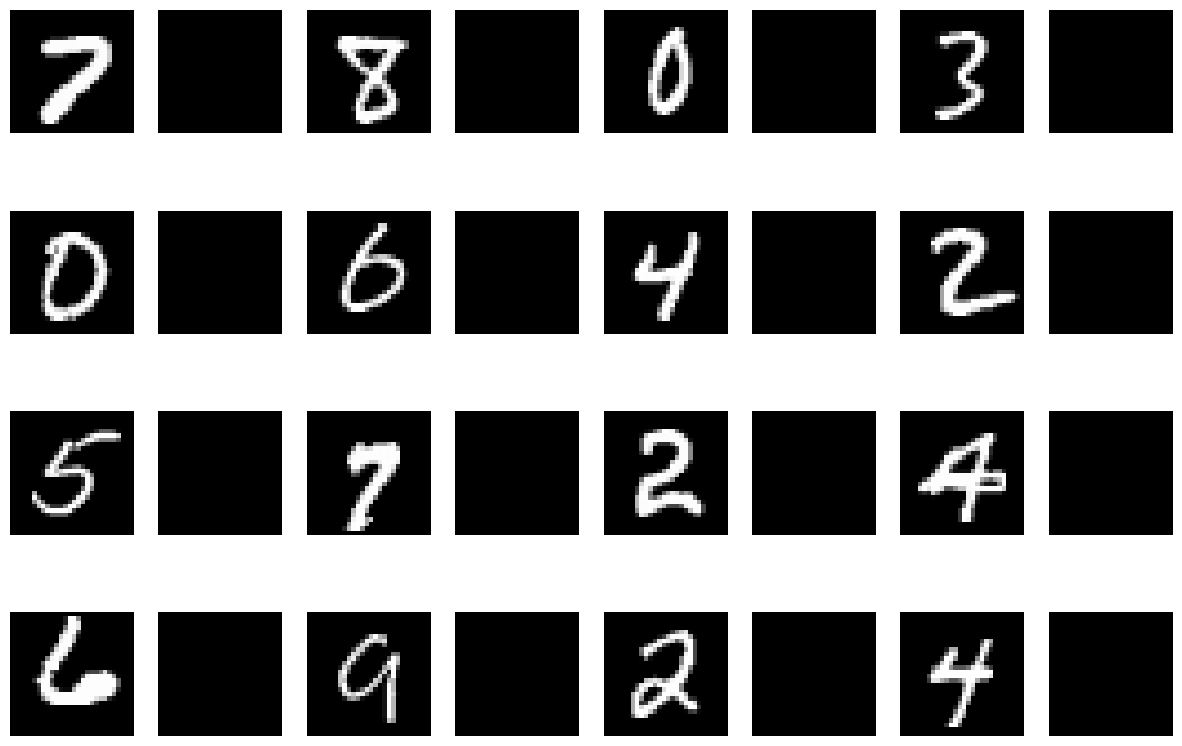

In [352]:
conv2_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer('conv2').output)
feature_map_conv2 = conv2_layer_model(x_test)

fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

ix=0
for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(x_test[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(feature_map_conv2[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j+1].axis('off')

Build and test a logistic regression model to classify two digits of your choice (i.e. a binary classification) using the features maps at the second convolutional layer as the input. You may use logistic regression functions such as [LogisticRegression in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Use 80% of the data for training and 20% for test.

* How many features are there in your input X? Show the derivation of this number based on the architecture of the convolutional neural network.

* How is your logistic regression model related to the fully connected layer and softmax layer in the convolutional neural network?

* What is the accuracy of your model? Is this expected, or surprising? 

* Comment on any other aspects of your findings that are interesting to you.


In [361]:
X_lr = np.reshape(feature_map_conv2,(np.shape(feature_map_conv2)[0],-1))
y_lr = y_test

### Answer

In [374]:
from sklearn.metrics import accuracy_score

# Filter for two digits: 3 and 7
binary_filter = (y_lr == 3) | (y_lr == 7)
X_binary = X_lr[binary_filter]
y_binary = y_lr[binary_filter]

# Split
X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)

# Train
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.9926470588235294


### Answer
There are 2048 features. The input image starts with a shape of 28x28. The first convolutional layer uses a 5x5 filter, which reduces the dimensions to 24x24 (since the effective filter size is 5, the output shrinks by 4). After applying 2x2 max-pooling, the shape becomes 12x12. The second convolutional layer, also using a 5x5 filter, reduces the size to 8x8. Since there are 32 filters in this layer, the final feature map has dimensions of 8x8x32. Flattening this gives 8 * 8 * 32 = 2048 features, which is the input to the logistic regression model.

This logistic regression model is the "practically" the same thing as the dense layer in our CNN, as both learn a weighted sum of the inputs to produce a prediction. The only difference is that in our CNN, the output passes through a softmax function for multi-class classification. For binary classification, this can be replaced by a sigmoid function, which is exactly a logistic regression model. The main difference is that, in this case, we precompute the feature maps from the convolutional layers and train the logistic regression model separately (a two-step process), whereas in a CNN, the feature extraction layers and FC layers are trained together in an end-to-end manner.

The model's accuracy is nearly 100%, which is expected for several reasons. First, binary classification is inherently simpler than multi-class classification, making it easier to achieve high accuracy. Second, the chosen digits, 3 and 7, have very distinct visual features, so their feature maps are quite different, making them easier to separate. Additionally, the feature maps learned by the CNN are highly informative, capturing key patterns from the input data. Since the dense layer in the CNN essentially functions like a logistic regression model, and CNNs achieve around 98% accuracy on the full multi-class MNIST task, it’s no surprise that performance is exceptional for binary classification.

## Problem 2: All that glitters (20 points)

In this problem you will use Gaussian process regression to model the trends in gold medal performances of selected events in the summer Olympics. The objectives of this problem are for you to:

* Gain experience with Gaussian processes, to better understand how they work
* Explore how posterior inference depends on the properties of the prior mean and kernel
* Use Bayesian inference to identify unusual events
* Practice making your Python code modular and reusable

For this problem, the only starter code we provide is to read in the data and extract 
one event. You may write any GP code that you choose to, but please do not use any 
package for Gaussian processes; your code should be "np-complete" (using only 
basic `numpy` methods). You are encouraged to start from the [GP demo code](https://ydata123.org/fa24/interml/calendar.html) used in class.


When we ran the GP demo code from class on the marathon data, it generated the following plot:
<img src="https://github.com/YData123/sds365-fa22/raw/main/assignments/assn2/marathon.jpg" width="600">

Note several properties of this plot:
* It shows the Bayesian confidence of the regression, as a shaded area. This is a 95% confidence band because it has width given by $\pm 2 \sqrt{V}$, where $V$ is the estimated variance. The variance increases at the right side, for future years.

* The gold medal time for the 1904 marathon is outside of this confidence band. In fact, the 1904 marathon was an [unusual event](https://www.smithsonianmag.com/history/the-1904-olympic-marathon-may-have-been-the-strangest-ever-14910747/), and this is apparent from the model. 

* The plot shows the posterior mean, and also shows one random sample from the posterior distribution.

Your task in this problem is generate such a plot for six different Olympic events by writing a function

`def gp_olympic_event(year, result, kernel, mean, noise, event_name):
    ...`
    
 where the input variables are the following:
 
* `year`: a numpy array of years (integers)
* `result`: a numpy array of numerical results, for the gold medal performances in that event
* `kernel`: a kernel function 
* `mean`: a mean function 
* `noise`: a single float for the variance of the noise, $\sigma^2$
* `event_name`: a string used to label the y-axis, for example "marathon min/mile (men's event)"
 
Your function should compute the Gaussian process regression, and then display the resulting plot, analogous to the plot above for the men's marathon event.

You will then process **six** of the events, three men's events and three women's events, and call your function to generate the corresponding six plots.

For each event, you should create a markdown cell that describes the resulting model. Comment on such things as:

* How you chose the kernel, mean, and noise.
* Why the plot does or doesn't look satisfactory to you
* If there are any events such as the 1904 marathon that are notable.
* What happens to the posterior mean (for example during WWII) if there are gaps in the data

Use your best judgement to describe your findings; post questions to EdD if things are unclear. And have fun!



------------------

In the remainder of this problem description, we recall how we processed the marathon data, as an example. The following cell reads in the data and displays the collection of events that are included in the dataset. 

In [185]:
# I added additional imports here
import numpy as np
import matplotlib.pyplot as plt

from time import sleep
from numpy.linalg import cholesky
from scipy.spatial.distance import cdist
from IPython.display import clear_output

# Orginal code
import numpy as np
import pandas as pd

dat = pd.read_csv('https://raw.githubusercontent.com/YData123/sds365-sp22/main/demos/gaussian_processes/olympic_results.csv')
events = set(np.array(dat['Event']))
print(events)

{'Pole Vault Women', '5000M Men', '110M Hurdles Men', '400M Women', '200M Men', 'Shot Put Women', '400M Hurdles Men', 'Shot Put Men', 'Hammer Throw Men', '10000M Men', '100M Men', '3000M Steeplechase Women', 'High Jump Men', 'Discus Throw Women', 'High Jump Women', '800M Men', 'Marathon Men', '200M Women', 'Triple Jump Men', '10000M Women', '4X100M Relay Women', 'Heptathlon Women', 'Javelin Throw Women', '3000M Steeplechase Men', '4X400M Relay Men', '800M Women', '4X100M Relay Men', '50Km Race Walk Men', '400M Men', 'Marathon Women', '1500M Women', '20Km Race Walk Women', '4X400M Relay Women', '400M Hurdles Women', '20Km Race Walk Men', '5000M Women', 'Hammer Throw Women', 'Discus Throw Men', 'Decathlon Men', 'Long Jump Men', 'Pole Vault Men', 'Javelin Throw Men', 'Long Jump Women', '100M Women', '100M Hurdles Women', 'Triple Jump Women', '1500M Men'}


We then process the time to compute the minutes per mile (without checking that the race was actually 26.2 miles!)

In [206]:
marathon = dat[dat['Event'] == 'Marathon Men']
marathon = marathon[marathon['Medal']=='G']
marathon = marathon.sort_values('Year')
time = np.array(marathon['Result'])
mpm = []
for tm in time:
    t = np.array(tm.split(':'), dtype=float)
    minutes_per_mile = (t[0]*60*60 + t[1]*60 + t[2])/(60*26.2)
    mpm.append(minutes_per_mile)
    
marathon['Minutes per Mile'] = np.round(mpm,2)
marathon = marathon.drop(columns=['Gender', 'Event'], axis=1)
marathon.reset_index(drop=True, inplace=True)
year = np.array(marathon['Year'])
result = np.array(marathon['Minutes per Mile'])
marathon

,Location,Year,Medal,Name,Nationality,Result,Minutes per Mile
0,Athens,1896,G,Spyridon LOUIS,GRE,2:58:50,6.83
1,Paris,1900,G,Michel THÃATO,FRA,2:59:45.0,6.86
2,St Louis,1904,G,Thomas HICKS,USA,3:28:53.0,7.97
3,London,1908,G,John HAYES,USA,2:55:18.4,6.69
4,Stockholm,1912,G,Kennedy Kane MCARTHUR,RSA,2:36:54.8,5.99
5,Antwerp,1920,G,Hannes KOLEHMAINEN,FIN,2:32:35.8,5.82
6,Paris,1924,G,Albin STENROOS,FIN,2:41:22.6,6.16
7,Amsterdam,1928,G,BoughÃ¨ra EL OUAFI,FRA,2:32:57,5.84
8,Los Angeles,1932,G,Juan Carlos ZABALA,ARG,2:31:36,5.79
9,Berlin,1936,G,Kitei SON,JPN,2:29:19.2,5.70


### Answer

Enter your code and markdown following this cell.

In [193]:
# Convert to seconds
def convert_to_sec(time_str):
    time_parts = time_str.split(':')
    # If the time has hours, minutes, and seconds
    if len(time_parts) == 3:  
        hours, minutes, seconds = time_parts
        return int(hours) * 3600 + int(minutes) * 60 + float(seconds)
    # If the time has minutes and seconds
    elif len(time_parts) == 2:  
        minutes, seconds = time_parts
        return int(minutes) * 60 + float(seconds)
    # If the time has seconds
    else:
        return float(time_parts[0])
    
# Get event data and convert results to average speed
def get_event_data(data, event_name, num_meter):
    event = data[data['Event'] == event_name]
    event = event[event['Medal']=='G']
    event = event.sort_values('Year')
    times = np.array(event['Result'])
    result = np.array([convert_to_sec(t) for t in times])
    result = num_meter / result
    year = np.array(event['Year'])
    return year, result

# MVN(mu, Sigma) = mu + Sigma^(-1/2) dot MVN(0, I)
def sample_gausian(mu, Sigma):
    A = cholesky(Sigma)
    Z = np.random.normal(loc=0, scale=1, size=len(mu))
    return np.dot(A, Z) + mu

# mu(x) to calculate mu by scaling I by mu
def calc_mean(x, mu=0):
    return mu * np.ones(len(x))

# K(x) to calculate Sigma by Mercer Kernel
def calc_gaussian_mercer_cov(x, z, h=1):
    K = np.zeros(len(x)*len(z)).reshape(len(x), len(z))
    for j in np.arange(K.shape[1]):
        K[:,j] = (1/h)*np.exp(-(x-z[j])**2/(2*h**2))
    return K

# Gausian Process Prediction for Olympic Event
def gp_olympic_event(year, result, kernel, mean, noise, event_name):
    '''
    We assume that m(X) (or Year) follows a prior distribution MVN(u(x), K(x))
    We assume that Y = m(X) + e where e follows a distribution MVN(0, sigma^2 I)
    We wish to predict posterior data given the existing data X and Y (or Year and Results)
    '''
    
    # Initialize training data
    X_train = np.array(year)
    y_train = np.array(result)
    I_train = np.eye(len(X_train))

    # Create testing data (500 evenly spaced out points from specified range)
    X_test = np.linspace(min(year) - 1, max(year) + 10, 500)
    I_test = np.eye(len(X_test))

    # Calculate Mean for training data and test data
    mu_train = calc_mean(X_train, mu=mean)
    mu_test = calc_mean(X_test, mu=mean)

    # Calculate Sigma for training data (or Mercer Kernel Matrix)
    Sigma_train = kernel(X_train, X_train, h=10)
    Sigma_train_test = kernel(X_train, X_test, h=10)
    Sigma_test = kernel(X_test, X_test, h=10)

    # Calculate MVN Sigma of Train and Test (2x2 Block Matrix)
    Sigma_train_test_11 = Sigma_train + noise * I_train
    Sigma_train_test_12 = Sigma_train_test
    Sigma_train_test_21 = Sigma_train_test.T
    Sigma_train_test_22 = Sigma_test + noise * I_test

    # Calculate Inverse of Sigma_train_test_11
    Sigma_train_test_11_inv = np.linalg.inv(Sigma_train_test_11)

    # Calculate E(Test | Train)
    pred_mu = mu_test + Sigma_train_test_21 @ Sigma_train_test_11_inv @ (y_train - mu_train)
    pred_Sigma = Sigma_train_test_22 - Sigma_train_test_21 @ Sigma_train_test_11_inv @ Sigma_train_test_12
    pred_var = np.diag(pred_Sigma)

    # 95% Confidence Interval (or +- 2 standard errors)
    lower_band = pred_mu - 2 * np.sqrt(pred_var)
    upper_band = pred_mu + 2 * np.sqrt(pred_var)
    
    # Sample Y from predicted mu and sigma
    y_test = gaussian_sample(pred_mu, pred_Sigma)

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(9, 6))
    ax.set_title(f"{event_name}", fontsize=16)
    ax.fill_between(X_test, lower_band, upper_band, step="pre", alpha=0.2, label='Posterior 95% confidence')
    ax.plot(X_test, y_test, c='r', linestyle='-', linewidth=.1, label='Sample from Posterior')
    ax.plot(X_test, pred_mu, c='black', linestyle='-', linewidth=.5, label='Posterior mean')
    ax.scatter(X_train, y_train, color='red', marker='o', linewidth=.4, label='Data')
    ax.set_xlabel('Year', fontsize=14)
    _ = ax.set_ylabel(f"Average Speed (M/S)", fontsize=14)
    ax.legend()

#### General Explanations for All Plots:
- 1) The Y-axis represents Average Speed in Meters per Second, calculated as (Total event length in meters) / (Total time in seconds).
- 2) The prior mean is set to the sample mean of observed average speeds, as it is the UMVUE (Uniformly Minimum Variance Unbiased Estimator) for the true mean.
- 3) The prior noise is set to np.square(5/60). Given that all events are races measured in meters, I assume the noise is consistent across races. In addition, I assume that uncertainties, such as race dynamics (e.g., fatigue, start variability), are consistently distributed over time, occurring roughly every minute.

#### 10000M Men

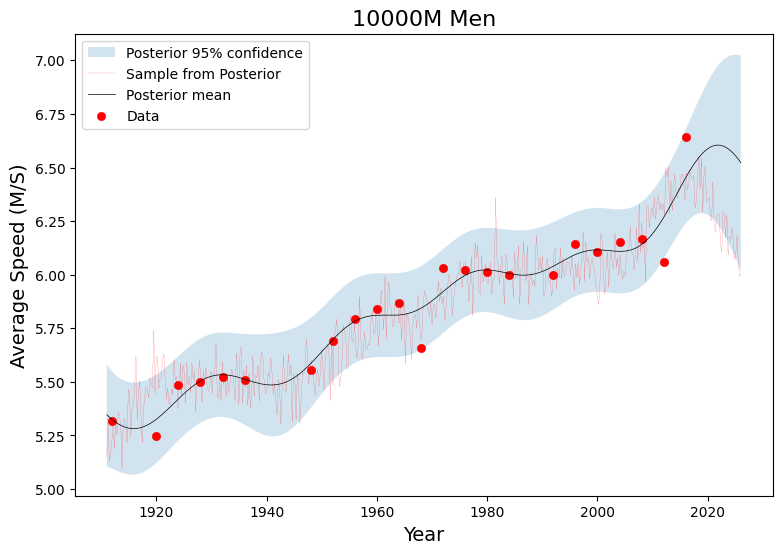

In [241]:
# Parameter
event_name = '10000M Men'
num_meter = 10000
year, result = get_event_data(dat, event_name, num_meter) # Event data
kernel = calc_gaussian_mercer_cov # Mercer Kernel Function
mean = result.mean() # Mean
noise = np.square(5/60) # Noise (or epsilon)
gp_olympic_event(year, result, kernel, mean, noise, event_name)

Overall, I believe the model fit is strong. The posterior means capture most data points effectively and exhibit a smooth trajectory, indicating minimal overfitting. In addition, the confidence bands capture a majority of the observed results. Notably, there's an increasing trend in average speed at a linear rate, suggesting that men racing in the 10,000M have become consistently faster over time. However, there are noticeable dips, such as in 1920, which could be attributed to the impact of World War I, likely disrupting training and performance.

#### 110M Hurdles Men

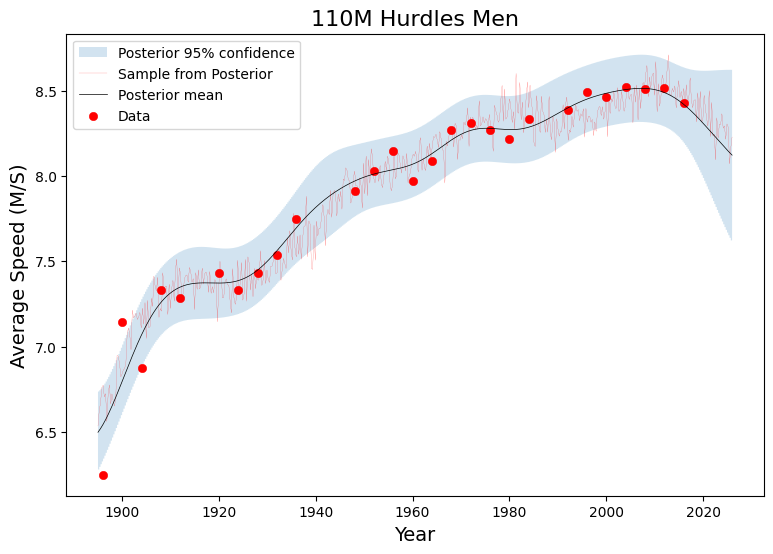

In [229]:
# Parameter
event_name = '110M Hurdles Men'
num_meter = 110
year, result = get_event_data(dat, event_name, num_meter) # Event data
kernel = calc_gaussian_mercer_cov # Mercer Kernel Function
mean = result.mean() # Mean
noise = np.square(5/60) # Noise (or epsilon)
gp_olympic_event(year, result, kernel, mean, noise, event_name)

Overall, the model fit appears robust. The posterior means effectively capture most data points, maintaining a smooth trajectory that suggests minimal overfitting. Additionally, the confidence bands encompass a majority of the observed results. Notably, there is a clear increasing trend in average speed from 1900 to 1960, which tapers off after 1960. This deceleration aligns with the fact that the 110M hurdles is a relatively short event, bringing athletes closer to the physical limits of human performance. In contrast, longer races offer more variability and room for improvement in average speed. After 2020, the model seems to struggle due to a lack of observed results, which leads to a predicted decline in speed.

#### 400M Men

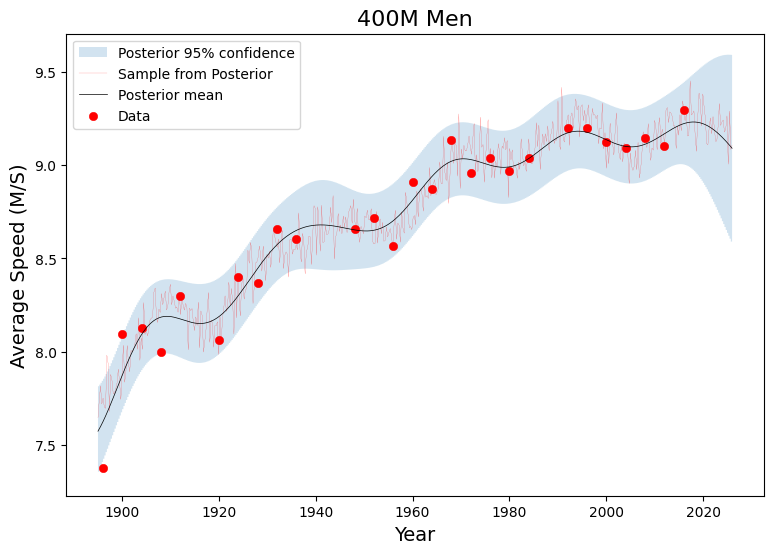

In [230]:
# Parameter
event_name = '400M Men'
num_meter = 400
year, result = get_event_data(dat, event_name, num_meter) # Event data
kernel = calc_gaussian_mercer_cov # Mercer Kernel Function
mean = result.mean() # Mean
noise = np.square(5/60) # Noise (or epsilon)
gp_olympic_event(year, result, kernel, mean, noise, event_name)

Overall, the model fit appears robust. The posterior means capture most data points effectively, maintaining a smooth trajectory that suggests minimal overfitting. Additionally, the confidence bands encompass the majority of the observed results. The model exhibits a periodic trend of increases and decreases, though this trend follows an upward linear trajectory. There is greater variability during WWI and WWII, likely due to disrupted training caused by the wars. As a result, the model appears to take a "safe" approach by estimating an average between these variable spikes.

#### 5000M Women

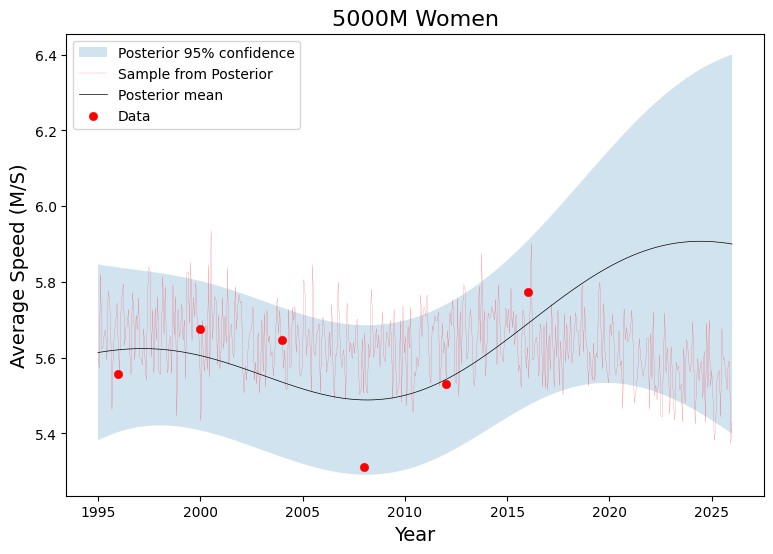

In [231]:
# Parameter
event_name = '5000M Women'
num_meter = 5000
year, result = get_event_data(dat, event_name, num_meter) # Event data
kernel = calc_gaussian_mercer_cov # Mercer Kernel Function
mean = result.mean() # Mean
noise = np.square(5/60) # Noise (or epsilon)
gp_olympic_event(year, result, kernel, mean, noise, event_name)

Overall, the model appears slightly underfitted. The posterior mean tracks the data points without overfitting to the observed results, likely due to the limited number of observations—only six for average speed. With such few data points, it’s challenging to draw definitive conclusions about whether speeds are increasing. However, the model does suggest a potential rise in average speed beyond 2015.

#### 1500M Women

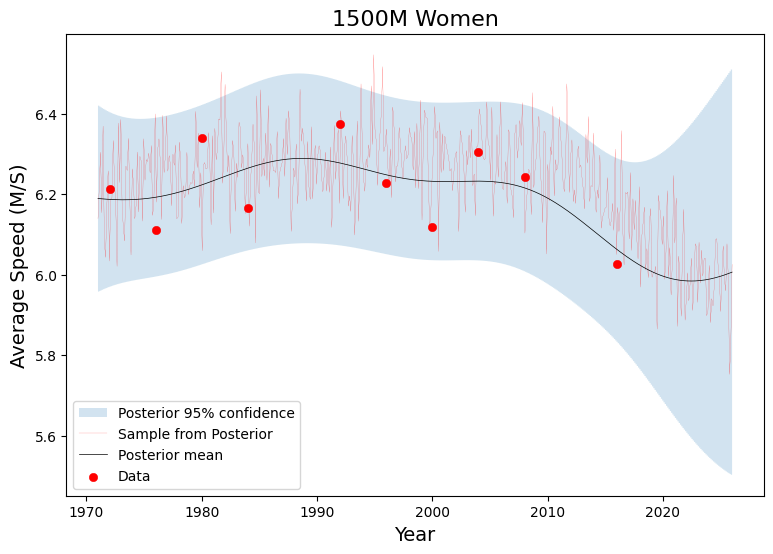

In [232]:
# Parameter
event_name = '1500M Women'
num_meter = 1500
year, result = get_event_data(dat, event_name, num_meter) # Event data
kernel = calc_gaussian_mercer_cov # Mercer Kernel Function
mean = result.mean() # Mean
noise = np.square(5/60) # Noise (or epsilon)
gp_olympic_event(year, result, kernel, mean, noise, event_name)

Overall, the model appears slightly underfitted. While the posterior mean tracks the data points, it never aligns with any observed results. Interestingly, the model suggests a slight downward trend in average speed, which is unexpected given advancements in technology and training conditions. Additionally, the model's confidence diminishes after 2020 due to the lack of observed results, indicating that the Gaussian Process struggles with extrapolation in this context.

#### 4X100M Relay Women

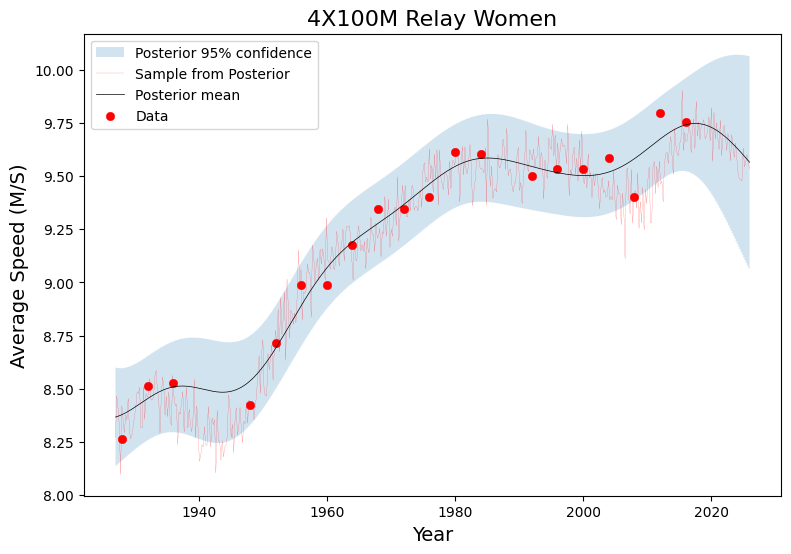

In [233]:
# Parameter
event_name = '4X100M Relay Women'
num_meter = 4*100
year, result = get_event_data(dat, event_name, num_meter) # Event data
kernel = calc_gaussian_mercer_cov # Mercer Kernel Function
mean = result.mean() # Mean
noise = np.square(5/60) # Noise (or epsilon)
gp_olympic_event(year, result, kernel, mean, noise, event_name)

Overall, the model fit appears robust. The posterior means capture most data points effectively, maintaining a smooth trajectory that suggests minimal overfitting. Additionally, the confidence bands cover the majority of observed results. The model shows a strong upward trend in average speed, with two notable dips—one around 1940, likely due to WWII, and another in 2008, possibly linked to the Financial Crisis. In both cases, the model demonstrates resilience to these disruptions, opting for an average estimate between the points rather than overreacting to the gaps.

## Problem 3: Double descent! (20 points)

<a href="https://skitheworld.com/2018/12/wurtele-twins-appointed-order-canada/"><img src="https://raw.githubusercontent.com/YData123/sds365-fa22/main/assignments/assn1/double.jpg" width="200" align="left" style="margin:10px 30px 10px 0px"></a>


In this problem you will explore the "double descent" phenomenon that was recently 
discovered as a key principle underlying the performance of deep neural networks.
The problem setup is a "random features" version of a 2-layer neural network. The weights in the first layer are random and fixed, and the weights in the second layer are estimated from data. As we increase the number of neurons in the hidden layer, the dimension $p$ of model increases. It's helpful to define the ratio $\gamma = p/n$ of variables to sample points. If $\gamma < 1$ then we want to use the OLS estimator, and if $\gamma > 1$ we want to use the minimum norm estimator. 
<br>

Your mission (should you choose to accept it), is

1. Implement a function `OLS_or_minimum_norm` that computes the least squares solution when $\gamma < 1$, and the minimum norm solution when $\gamma > 1$. (When $\gamma=1$ the estimator does not, in general, exist.)
1. Run the main code we give you to average over many trials, and to compute and plot the estimated risk for a range of values of $\gamma$. 
1. Next, extend the starter code so that you compute (estimates of) the squared-bias and variance of the models. To do this, note that you'll need access to the true regression function, which is provided. You may want to refer to the demo code for smoothing kernels as an example.
1. Using your new code, extend the plotting function we provide so that you plot 
the squared-bias, variance, and risk together on the same plot. 
1. Finally, comment on the results, describing why it might make sense that the squared bias, variance, and risk have the given shapes that they do.
1. Show that in the overparameterized regime $\gamma > 1$, as $\lambda \to 0$, the ridge regression estimator converges to the minimum norm estimator.


By doing this exercise you will solidify your understanding of the meaning of bias and variance, and also gain a better understanding of the "double descent" phenomenon for overparameterized neural networks, 
and their striking resistance to overfitting.

We're available in OH to help with any issues you run into!

If you have any interest in background reading on this topic (not expected or required), we recommend Hastie et al., ["Surprises in high-dimensional ridgeless least squares regression"](https://www.stat.cmu.edu/~ryantibs/papers/ridgeless.pdf).



In [263]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

### Problem 3.1

Implement the function `OLS_or_minimum_norm` that computes the OLS solution for $\gamma < 1$, and the minimum norm solution for $\gamma > 1$.

In [289]:
def OLS_or_minimum_norm(X, y):
    ## Your code here
    n = X.shape[0]
    p = X.shape[1]
    
    if n > p:  # OLS
        return np.linalg.solve(X.T @ X, X.T @ y)
    else:  # Minimum Norm
        return X.T @ np.linalg.solve(X @ X.T, y)

In [290]:
# A plotting function we provide. No need to change this, although you can if you'd like.

def plot_double_descent_risk(gammas, risk, sigma):
    gammas = np.round(gammas, 2)
    fig, ax = plt.subplots(figsize=(10,6))
    tick_pos = np.zeros(len(gammas))
    for i in np.arange(len(gammas)):
        if gammas[i] <= 1:
            tick_pos[i] = gammas[i] * 10
        else:
            tick_pos[i] = gammas[i] + 9
    ax.axvline(x=tick_pos[np.array(gammas)==1][0], linestyle='dashed', color='gray')
    ax.axhline(y=sigma**2, linestyle='dashed', color='gray')
    ax.scatter(tick_pos, risk, color='salmon')
    ax.plot(tick_pos, risk, color='gray', linewidth=.5)

    tickgam = [gam for gam in gammas if (gam > .05 and gam <= .9) or gam >= 2 or gam == 1]
    ticks = [tick_pos[j] for j in np.arange(len(tick_pos)) if gammas[j] in tickgam]
    ax.xaxis.set_ticks(ticks)
    ax.xaxis.set_ticklabels(tickgam)

    plt.xlabel(r'$\gamma = \frac{p}{n}$', fontsize=18)
    _ = plt.ylabel('Risk', fontsize=18)

### Data setup 

The following cell sets up our data. The inputs $X$ are 
random Gaussian vectors of dimension $d=10$. Then, we map these 
using a neural network with fixed, Gaussian weights, to get random features
corresponding to $p^* = 150$ hidden neurons. The second layer 
coefficients are $\beta^* \in {\mathbb R}^{p^*}$, which are fixed. 
This defines the true model.


In [291]:
# just execute this cell, after you define the function above.

np.random.seed(123456)

sigma = 1
d = 10
p_star = 150
signal_size = 5

W_star = (1/np.sqrt(d)) * np.random.randn(d, p_star)
beta_star = np.arange(p_star)
beta_star = signal_size * beta_star / np.sqrt(np.sum(beta_star**2))

N = 10000
X = np.random.randn(N, d)

# f_star is the true regression function, for computing the squared bias
f_star = np.dot(np.tanh(np.dot(X, W_star)), beta_star)
noise = sigma * np.random.randn(N)
y = f_star + noise
yf = np.concatenate((y.reshape(N,1), f_star.reshape(N,1)), axis=1)

### Train a sequence of models for different values of $\gamma$

Next, we train a sequence of models for different values of $\gamma$, always 
fixing the sample size at $n=200$, but varying the dimension $p = \gamma n$. 
When $p < p^*$ we just take the first $p$ features in the true model. 
When $p > p^*$ we add $p-p^*$ neurons to the hidden layer, with their 
own random weights.

In the code below, we loop over the different values of $\gamma$, 
and for each $\gamma$ we run $100$ trials, each time generating 
a new training set of size $n=200$. The model (either OLS or minimum norm) is then computed, the MSE is computed, and finally the risk is estimated by averaging over all $100$ trials.


In [ ]:
trials = 100
n = 200

gammas = list(np.arange(.1, 1, .1)) + [.92, .94, 1, 1.1, 1.2, 1.4, 1.6] + list(np.arange(2, 11, 1))
gammas = [.01, .05] + gammas
risk = []
for gamma in gammas:
    err = []
    p = int(n * gamma)
    if gamma == 1:
        risk.append(np.inf)
        continue
    W = (1/np.sqrt(d)) * np.random.randn(d, p)
    W[:,:min(p, p_star)] = W_star[:,:min(p, p_star)]
    for i in np.arange(trials):
        X_train, X_test, yf_train, yf_test = train_test_split(X, yf, train_size=n, test_size=1000)
        H_train = np.tanh(np.dot(X_train, W))
        H_test = np.tanh(np.dot(X_test, W))
        beta_hat = OLS_or_minimum_norm(H_train, yf_train[:,0])
        yhat_test = H_test @ beta_hat 
        
        # Squared Bias, Variance, Risk
        yf_test_official = yf_test[:, 0]
        sq_bias = np.mean(yhat_test - yf_test_official)**2
        sq_biasj = np.mean(np.mean(yhat_test, axis=0) - yf_test_official)**2
        var = np.mean(np.var(yhat_test, axis=0))
        risk = np.mean((yhat_test - yf_test_official)**2)
        err.append(np.mean((yhat_test - yf_test[:,0])**2))
        
    print('gamma=%.2f  p=%d  n=%d  risk=%.3f' % (gamma, p, n, np.mean(err)))
    risk.append(np.mean(err))


### I edit the code above to be Parallelized across each trial per Gamma use Joblib to make it faster

In [267]:
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

# Parallel trial function
def run_trial(X, yf, W, d, p, n, sigma):
    X_train, X_test, yf_train, yf_test = train_test_split(X, yf, train_size=n, test_size=1000)
    H_train = np.tanh(np.dot(X_train, W))
    H_test = np.tanh(np.dot(X_test, W))
    beta_hat = OLS_or_minimum_norm(H_train, yf_train[:, 0])
    yhat_test = H_test @ beta_hat
    return np.mean((yhat_test - yf_test[:, 0])**2)

# Params
trials = 100
n = 200

gammas = list(np.arange(.1, 1, .1)) + [.92, .94, 1, 1.1, 1.2, 1.4, 1.6] + list(np.arange(2, 11, 1))
gammas = [.01, .05] + gammas
risk = []

# Run
for gamma in tqdm(gammas, desc='Gamma'):
    if gamma == 1:
        risk.append(np.inf)
        continue
    p = int(n * gamma)
    W = (1/np.sqrt(d)) * np.random.randn(d, p)
    W[:, :min(p, p_star)] = W_star[:, :min(p, p_star)]

    # Use Parallel for running trials in parallel
    errs = Parallel(n_jobs=-1)(delayed(run_trial)(X, yf, W, d, p, n, sigma) for _ in range(trials))
    risk.append(np.mean(errs))
    print('gamma=%.2f  p=%d  n=%d  risk=%.3f' % (gamma, p, n, np.mean(errs)))

Gamma:   0%|          | 0/27 [00:00<?, ?it/s]

gamma=0.01  p=2  n=200  risk=7.364
gamma=0.05  p=10  n=200  risk=4.176
gamma=0.10  p=20  n=200  risk=2.293
gamma=0.20  p=40  n=200  risk=2.133
gamma=0.30  p=60  n=200  risk=2.301
gamma=0.40  p=80  n=200  risk=2.517
gamma=0.50  p=100  n=200  risk=3.080
gamma=0.60  p=120  n=200  risk=3.546
gamma=0.70  p=140  n=200  risk=4.493
gamma=0.80  p=160  n=200  risk=7.326
gamma=0.90  p=180  n=200  risk=16.849
gamma=0.92  p=184  n=200  risk=19.528
gamma=0.94  p=188  n=200  risk=29.947
gamma=1.10  p=220  n=200  risk=23.635
gamma=1.20  p=240  n=200  risk=13.756
gamma=1.40  p=280  n=200  risk=8.461
gamma=1.60  p=320  n=200  risk=6.297
gamma=2.00  p=400  n=200  risk=5.128
gamma=3.00  p=600  n=200  risk=4.074
gamma=4.00  p=800  n=200  risk=3.539
gamma=5.00  p=1000  n=200  risk=3.537
gamma=6.00  p=1200  n=200  risk=3.334
gamma=7.00  p=1400  n=200  risk=3.149
gamma=8.00  p=1600  n=200  risk=3.186
gamma=9.00  p=1800  n=200  risk=3.070
gamma=10.00  p=2000  n=200  risk=3.017


### Plot the risk

At this point, you can plot the risk by just evaluating the cell below. 
This should reveal the "double descent" behavior.


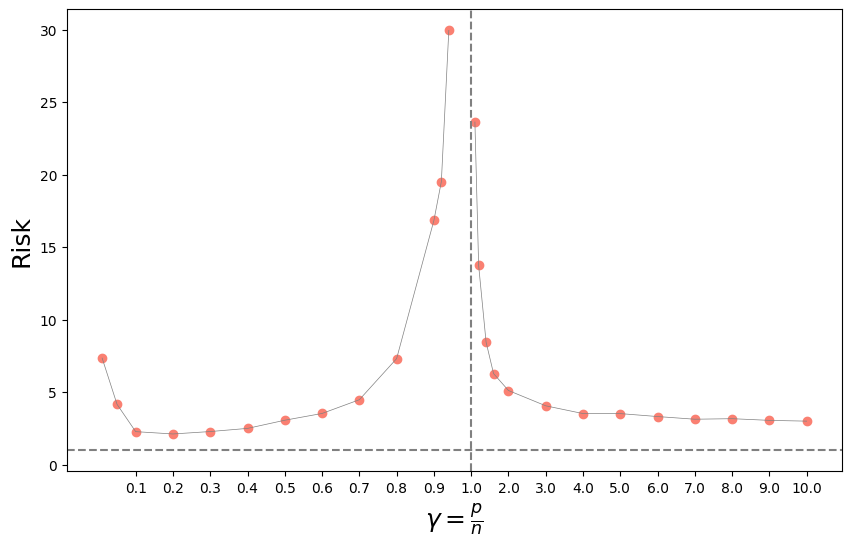

In [268]:
# Just evaluate the next line 
plot_double_descent_risk(gammas, risk, sigma)

### Problem 3.2

Comment on the results. Explain why the risk plot does or does not make sense 
in each regime: The underparameterized regime $\gamma < 1$, and the overparameterized 
regime $\gamma > 1$. Is the curve "U-shaped" in the underparameterized regime? Why or why not?
What about in the overparameterized regime? You will be able to give better answers to these questions when you estimate the bias and variance below.


### Answer
First consider the underparameterized regime where $\gamma < 1$. In this case, we observe the classic U-shaped risk curve. As the number of parameters \(p\) increases, variance grows while bias decreases. Initially, the reduction in bias leads to a decrease in risk. However, as \(p\) approaches \(n\), the increasing variance starts to dominate, causing a sharp rise in the overall risk. This behavior is expected, as fitting more parameters typically increases the model’s sensitivity to noise.

Now, in the overparameterized regime where $\gamma > 1$, the behavior is more unexpected. As \(p\) continues to increase, risk rapidly decreases and converges to a level slightly above the minimum risk achieved by ordinary least squares (OLS). This is surprising because we might expect the variance to increase indefinitely as \(p\) grows, given that the model can perfectly interpolate the training data. However, the sharp decline in risk suggests that the model's capacity to interpolate the data does not necessarily lead to higher risk, likely due to the way overparameterization affects the bias-variance tradeoff in this regime.


### Problem 3.3

Now, modify the above code so that you can estimate both the squared bias and the 
variance of the estimator. Before you do this, you may want to revisit the kernel smoothing demo from class, where we computed the squared bias, variance, and risk. You'll need the true function, which is provided in the variable `yf`.  You should not have to write a lot of code, but can compute the bias and variance after you store the predicted values on the test data for each trial.

Plot the results, by plotting both the squared bias, the variance, and the risk for the sequence of gammas. To do this you will have to modify the plotting function appropriately, but this again involves minimal changes. When you obtain your final plot, comment 
on the shape of the bias and variance curves, as above for Problem 3.2.


In [313]:
# A plotting function we provide. No need to change this, although you can if you'd like.

# Plotting function modified for bias and variance
def plot_double_descent_metrics(gammas, sq_bias, var, risk, sigma):
    gammas = np.round(gammas, 2)
    fig, ax = plt.subplots(figsize=(10,6))
    tick_pos = np.zeros(len(gammas))
    
    for i in np.arange(len(gammas)):
        if gammas[i] <= 1:
            tick_pos[i] = gammas[i] * 10
        else:
            tick_pos[i] = gammas[i] + 9
            
    ax.axvline(x=tick_pos[np.array(gammas) == 1][0], linestyle='dashed', color='gray')
    ax.axhline(y=sigma**2, linestyle='dashed', color='gray')

    # Plot sq_bias, var, and risk
    ax.scatter(tick_pos, sq_bias, color='blue', label='Squared Bias')
    ax.plot(tick_pos, sq_bias, color='blue', linewidth=.5)
    
    ax.scatter(tick_pos, var, color='green', label='Variance')
    ax.plot(tick_pos, var, color='green', linewidth=.5)

    ax.scatter(tick_pos, risk, color='salmon', label='Risk')
    ax.plot(tick_pos, risk, color='gray', linewidth=.5)

    tickgam = [gam for gam in gammas if (gam > .05 and gam <= .9) or gam >= 2 or gam == 1]
    ticks = [tick_pos[j] for j in np.arange(len(tick_pos)) if gammas[j] in tickgam]
    ax.xaxis.set_ticks(ticks)
    ax.xaxis.set_ticklabels(tickgam)

    plt.xlabel(r'$\gamma = \frac{p}{n}$', fontsize=18)
    plt.ylabel('Metrics', fontsize=18)
    plt.legend()
    plt.show()

In [320]:
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

# Parallel trial function
def run_trial(X, yf, W, d, p, n, sigma):
    X_train, X_test, yf_train, yf_test = train_test_split(X, yf, train_size=n, test_size=1000)
    H_train = np.tanh(np.dot(X_train, W))
    H_test = np.tanh(np.dot(X_test, W))
    beta_hat = OLS_or_minimum_norm(H_train, yf_train[:, 0])
    yhat_test = H_test @ beta_hat
    
    # Squared Bias, Variance, Risk
    yf_test_official = yf_test[:, 0]
    sq_bias = np.mean(np.mean(yhat_test, axis=0) - yf_test_official)**2
    var = np.mean(np.var(yhat_test, axis=0))
    risk = np.mean((yhat_test - yf_test_official)**2)
    return sq_bias, var, risk

# Params
trials = 100
n = 200

gammas = list(np.arange(.1, 1, .1)) + [.92, .94, 1, 1.1, 1.2, 1.4, 1.6] + list(np.arange(2, 11, 1))
gammas = [.01, .05] + gammas
sq_biases = []
vars_ = []
risks = []

# Run
for gamma in tqdm(gammas, desc='Gamma'):
    if gamma == 1:
        sq_biases.append(np.inf)
        vars_.append(np.inf)
        risks.append(np.inf)
        continue
    p = int(n * gamma)
    W = (1/np.sqrt(d)) * np.random.randn(d, p)
    W[:, :min(p, p_star)] = W_star[:, :min(p, p_star)]

    # Use Parallel for running trials in parallel
    results = Parallel(n_jobs=-1)(delayed(run_trial)(X, yf, W, d, p, n, sigma) for _ in range(trials))
    sq_bias_avg, var_avg, risk_avg = np.mean(results, axis=0)
    
    sq_biases.append(sq_bias_avg)
    vars_.append(var_avg)
    risks.append(risk_avg)
    
    print(f'gamma={gamma:.2f}  p={p}  n={n}  sq_bias={sq_bias_avg:.3f}  var={var_avg:.3f}  risk={risk_avg:.3f}')

Gamma:   0%|          | 0/27 [00:00<?, ?it/s]

gamma=0.01  p=2  n=200  sq_bias=0.007  var=6.566  risk=7.382
gamma=0.05  p=10  n=200  sq_bias=0.004  var=10.337  risk=4.162
gamma=0.10  p=20  n=200  sq_bias=0.002  var=12.283  risk=2.267
gamma=0.20  p=40  n=200  sq_bias=0.002  var=12.713  risk=2.113
gamma=0.30  p=60  n=200  sq_bias=0.003  var=13.526  risk=2.278
gamma=0.40  p=80  n=200  sq_bias=0.004  var=13.860  risk=2.598
gamma=0.50  p=100  n=200  sq_bias=0.003  var=14.255  risk=3.015
gamma=0.60  p=120  n=200  sq_bias=0.004  var=15.345  risk=3.643
gamma=0.70  p=140  n=200  sq_bias=0.005  var=16.354  risk=4.519
gamma=0.80  p=160  n=200  sq_bias=0.007  var=19.256  risk=7.149
gamma=0.90  p=180  n=200  sq_bias=0.013  var=27.122  risk=14.749
gamma=0.92  p=184  n=200  sq_bias=0.018  var=32.629  risk=20.732
gamma=0.94  p=188  n=200  sq_bias=0.027  var=40.573  risk=28.852
gamma=1.10  p=220  n=200  sq_bias=0.026  var=35.487  risk=23.157
gamma=1.20  p=240  n=200  sq_bias=0.012  var=24.876  risk=12.972
gamma=1.40  p=280  n=200  sq_bias=0.007  va

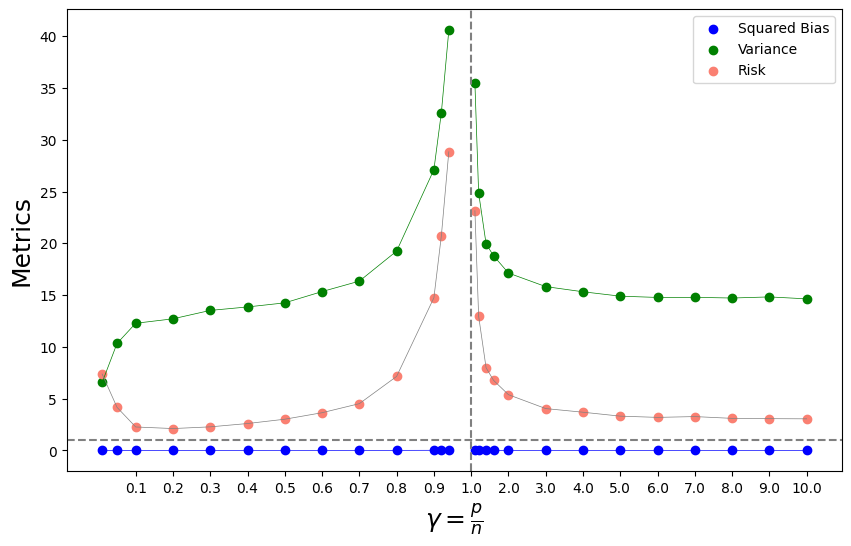

In [321]:
# Just evaluate the next line 
plot_double_descent_metrics(gammas, sq_biases, vars_, risks, sigma)

### Answer
First, examining the variance curves when $\gamma < 1$, we observe that as $p$ approaches $n$, variance initially increases slowly but then rises sharply as $p$ nears $n$. This effect is evident in both the Risk and Variance measures. This aligns with the understanding that as the model complexity increases, it not only fits the data better but also begins to capture noise, leading to poor generalization.

For $\gamma > 1$, variance behaves differently. As $p$ increases beyond $n$, variance decreases from the initial spike observed at $p = n$. This phenomenon can be explained by the \textit{minimum norm solution}. When $p > n$, the model has more parameters than data points, and in such cases, the minimum norm solution provides the smallest norm among all possible solutions, reducing overfitting and thus decreasing variance.

Regarding bias, we see that as $p$ increases, bias generally decreases except when $p$ nears $n$ for $\gamma < 1$, which is likely due to overfitting. However, for $\gamma > 1$, as $p$ continues to increase, the model transitions into an interpolator, where squared bias nearly vanishes, indicating almost perfect fit to the data.

### Problem 3.4

In class, we discussed the interpretation of the minimum-norm estimator $ \hat{\beta}_{\text{mn}} $. Geometrically, we can describe $ \hat{\beta}_{\text{mn}} $ as the orthogonal projection of the zero vector in $ \mathbb{R}^p $ onto the $ (p-1) $-dimensional hyperplane $ \{ \beta : X\beta = Y \} $.  

This can also be viewed as "ridgeless" regression. In ridge regression, we minimize the objective function
$$
\| Y - X\beta  \|_2^2 + \lambda \| \beta \|_2^2,
$$
which has the closed-form solution
$$
\hat{\beta}_{\lambda} = (X^T X + \lambda I)^{-1} X^T Y.
$$

In the overparameterized regime where $ p > n $, it can be shown that as $ \lambda \to 0 $, $ \hat{\beta}_{\lambda} $ converges to $ \hat{\beta}_{\text{mn}} $. 

Your task is to show that as $ \lambda \to 0 $, the limit of the ridge regression estimator $ \hat{\beta}_{\lambda} $, in the overparameterized regime where $ \gamma > 1 $, is the minimum-norm estimator $ \hat{\beta}_{\text{mn}} $. You may want to use the Woodbury formula for this derivation.


_Hint_:
1. Applying the simplified version of Woodbury formula
$$
(I + UV^T)^{-1} = I - U(I + V^T U)^{-1} V^T.
$$ 
we can derive the identity:
$$
(X^T X + \lambda I_p)^{-1} X^T = X^T (X X^T + \lambda I_n)^{-1},
$$
2. You might consider using the Woodbury formula twice.



### Answer
**Lemma 1**: We have the following identity:
\begin{align}
(I + A)^{-1}A = I - (I+A)^{-1}
\end{align}
**Proof**:
It follows simply that:
\begin{align}
(I + A)^{-1}A &= (I + A)^{-1}((I+A)-I) \\ &= (I + A)^{-1}(I+A) - (I + A)^{-1}I  \\&=I - (I+A)^{-1} \, \square
\end{align}

**Lemma 2**: We have the following identity
\begin{align}
(X^T X + \lambda I_p)^{-1} X^T = X^T (X X^T + \lambda I_n)^{-1},
\end{align}
**Proof**:
Define the variables:
\begin{align}
V &= X^T \\
U &= X^T \\
\end{align}
Then it follows that from Woodbury Formula that:
\begin{align}
(I + UV^T)^{-1} &= I - U(I + V^T U)^{-1} V^T \\
(I + X^TX)^{-1} &= I - X^T(I + X X^T)^{-1} X
\end{align}
Multiply both sides by $X^T$:
\begin{align}
(I + X^TX)^{-1}X^T &= X^T - X^T(I + X X^T)^{-1} XX^T
\end{align}
We now examine the last term $(I + X X^T)^{-1} XX^T$. Define the variable:
\begin{align}
A &= XX^T\\
(I + X X^T)^{-1} XX^T &= (I + A)^{-1} A
\end{align}
Then if follows directly from **Lemma 1** that:
\begin{align}
(I + A)^{-1} A &= I - (I + A)^{-1}\\
 &= I - (I + XX^T)^{-1} 
\end{align}
Substituting this back in to the equation we have:
\begin{align}
(I + X^TX)^{-1}X^T &= X^T - X^T(I - (I + XX^T)^{-1}) \\
&= X^T - X^T + X^T(I + XX^T)^{-1}\\
&= X^T(I + XX^T)^{-1}
\end{align}
Substituting $I$ for $\lambda I$ with correct dimensions we arrive at:
\begin{align}
(X^T X + \lambda I_p)^{-1} X^T = X^T (X X^T + \lambda I_n)^{-1} \, \square
\end{align}

**Proof of Convergence**:
We are tasked with showing that the ridge regression estimator 
$
\hat{\beta}_{\lambda} = (X^T X + \lambda I_p)^{-1} X^T Y
$
converges to the minimum-norm estimator $ \hat{\beta}_{\text{mn}} $ as $\lambda \to 0 $, in the overparameterized regime where $p > n $. 

By **Lemma 2** we have:
\begin{align}
(X^T X + \lambda I_p)^{-1} X^T &= X^T (X X^T + \lambda I_n)^{-1}
\end{align}

Thus, the ridge regression estimator becomes:
\begin{align}
\hat{\beta}_{\lambda} &= X^T (X X^T + \lambda I_n)^{-1} Y
\end{align}

Now, consider the limit as $\lambda \to 0 $. Since $ X X^T \in \mathbb{R}^{n \times n} $is invertible when $ X $ has full rank, we have:
\begin{align}
\lim_{\lambda \to 0} (X X^T + \lambda I_n)^{-1} &= (X X^T)^{-1}
\end{align}

Thus we can conclude that:
\begin{align}
\lim_{\lambda \to 0} \hat{\beta}_{\lambda} &= X^T (X X^T)^{-1} Y. \label{limit_solution} = \hat{\beta}_{\text{mn}}
\end{align}

Now, consider the case when $X X^T$ is not full rank and is not invertible. This results in the convergence:
\begin{align}
\lim_{\lambda \to 0} (X X^T + \lambda I_n)^{-1} &= (X X^T)^+,
\end{align}
where $(X X^T)^+$ denotes the Moore-Penrose pseudoinverse.

Thus we can conclude that:
\begin{align}
\lim_{\lambda \to 0} \hat{\beta}_{\lambda} &= X^T (X X^T)^+ Y = \hat{\beta}_{\text{mn}} \, \square
\end{align}